<a href="https://colab.research.google.com/github/Richardjmorton/colab/blob/master/prep_coronal_hole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install sunpy
!pip install aiapy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 501.9/501.9 kB 3.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 78.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.2/101.2 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.8/195.8 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.9/206.9 kB 27.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 99.0 MB/s eta 0:00:00
  Created wheel for aiapy: filename=aiapy-0.7.4-py3-none-any.whl size=54822 sha256=98ee6b7ffbb00

Dates of AIA data to read in

In [2]:
dates = ['2010-05-23','2011-05-23','2012-05-27','2013-04-24','2014-05-01','2015-05-23', '2016-05-23','2017-05-23']


Create directories to save into

In [ ]:
import os
from os.path import exists

for date in dates:
  path = '/content/drive/MyDrive/sdo_cor_hole_data/'+date
  if not exists(path):
    os.mkdir(path)


In [3]:
from sunpy.net import Fido, attrs
import astropy.units as u

import numpy as np

Download data using sunpy

In [ ]:
for date in dates[7:]:
  time = attrs.Time(date+' 01:00:00',date+' 01:08:50')
  res = Fido.search(time, attrs.Instrument.aia, attrs.Wavelength(94*u.Angstrom, 335*u.Angstrom))
  vals = np.where(res[0]['Wavelength'] != 304*u.Angstrom)
  #to_get = res[0][vals[0][0]+1:vals[0][0]+7]
  vals2 = np.unique(vals[0])
  to_get = res[0][vals2]
  files = Fido.fetch(to_get, path='/content/drive/MyDrive/sdo_cor_hole_data/{}/'.format(date), overwrite=False)

Files Downloaded:   0%|          | 0/265 [00:00<?, ?file/s]

265/0 files failed to download. Please check `.errors` for details


In [ ]:
files = Fido.fetch(files, path='/content/drive/MyDrive/sdo_cor_hole_data/{}/'.format(date))

Files Downloaded:   0%|          | 0/15 [00:00<?, ?file/s]

5/0 files failed to download. Please check `.errors` for details


In [ ]:
files = Fido.fetch(files, path='/content/drive/MyDrive/sdo_cor_hole_data/{}/'.format(date))

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

aia_lev1_193a_2017_05_23t01_00_16_84z_image_lev1.fits:   0%|          | 0.00/11.2M [00:00<?, ?B/s]

# Data prep

In [8]:
import astropy.time as atime
from astropy.coordinates import SkyCoord

from sunpy.map import Map

import glob

from aiapy.calibrate import correct_degradation, normalize_exposure
from aiapy.calibrate.util import get_correction_table
from aiapy.calibrate import register, update_pointing, degradation
from aiapy.psf import psf, deconvolve

import numpy as np

In [4]:
date = dates[7]
files = glob.glob('/content/drive/MyDrive/sdo_cor_hole_data/{}/*lev1*.fits'.format(date))


In [5]:
print(len(files))
files[0:6]

169


['/content/drive/MyDrive/sdo_cor_hole_data/2017-05-23/aia_lev1_94a_2017_05_23t01_00_11_12z_image_lev1.fits',
 '/content/drive/MyDrive/sdo_cor_hole_data/2017-05-23/aia_lev1_131a_2017_05_23t01_00_06_62z_image_lev1.fits',
 '/content/drive/MyDrive/sdo_cor_hole_data/2017-05-23/aia_lev1_335a_2017_05_23t01_00_12_62z_image_lev1.fits',
 '/content/drive/MyDrive/sdo_cor_hole_data/2017-05-23/aia_lev1_211a_2017_05_23t01_00_09_63z_image_lev1.fits',
 '/content/drive/MyDrive/sdo_cor_hole_data/2017-05-23/aia_lev1_171a_2017_05_23t01_00_09_35z_image_lev1.fits',
 '/content/drive/MyDrive/sdo_cor_hole_data/2017-05-23/aia_lev1_193a_2017_05_23t01_00_16_84z_image_lev1.fits']

In [6]:
sdo_maps = Map(files)

In [7]:
wvn = [m.meta['wavelnth'] for m in sdo_maps]
wvn_un = np.unique(wvn)
print(wvn_un)

NameError: ignored

In [ ]:
wvn_un[wvn_un == 171]

array([171])

Calculate Point Spread functions and deconvolve data (takes around 3 minutes to complete)

In [9]:
psfs = [psf(wv*u.Angstrom) for wv in wvn_un]
psfs = np.array(psfs)

NameError: ignored

In [ ]:
np.savez('/content/drive/MyDrive/sdo_cor_hole_data/psf.npz',psfs=psfs,wvn_un=wvn_un)

In [1]:
red_in = np.load('/content/drive/MyDrive/sdo_cor_hole_data/psf.npz')

NameError: ignored

In [9]:
psfs = red_in['psfs']
wvn_un = red_in['wvn_un']

In [ ]:
n_maps = len(sdo_maps)

for i in range(n_maps):
    m = sdo_maps[i]
    wv = m.meta['wavelnth']
    psf_wv = psfs[wvn_un == int(wv)]
    sdo_maps[i] = deconvolve(m, psf_wv[0])


Do additional SDO prep

In [ ]:
#sdo_prep=[]
for i in range(n_maps):
    m = sdo_maps[i]
    m_temp = update_pointing(m)
    reg = register(m_temp)
    if reg.data.shape[0] != 4096:
        data = np.pad(reg.data,((0,2),(0,2)))
        meta = reg.fits_header
        meta['crpix1']+=1
        meta['crpix2']+=1
        reg = Map(data, meta)
    corr_deg = correct_degradation(reg)
    #norm_exp = normalize_exposure(corr_deg)
    #sdo_prep.append(corr_deg)
    sdo_maps[i] = corr_deg

/usr/local/lib/python3.10/dist-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/usr/local/lib/python3.10/dist-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/usr/local/lib/python3.10/dist-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 100 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/usr/local/lib/python3.10/dist-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/usr/local/lib/python3.10/dist-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.form

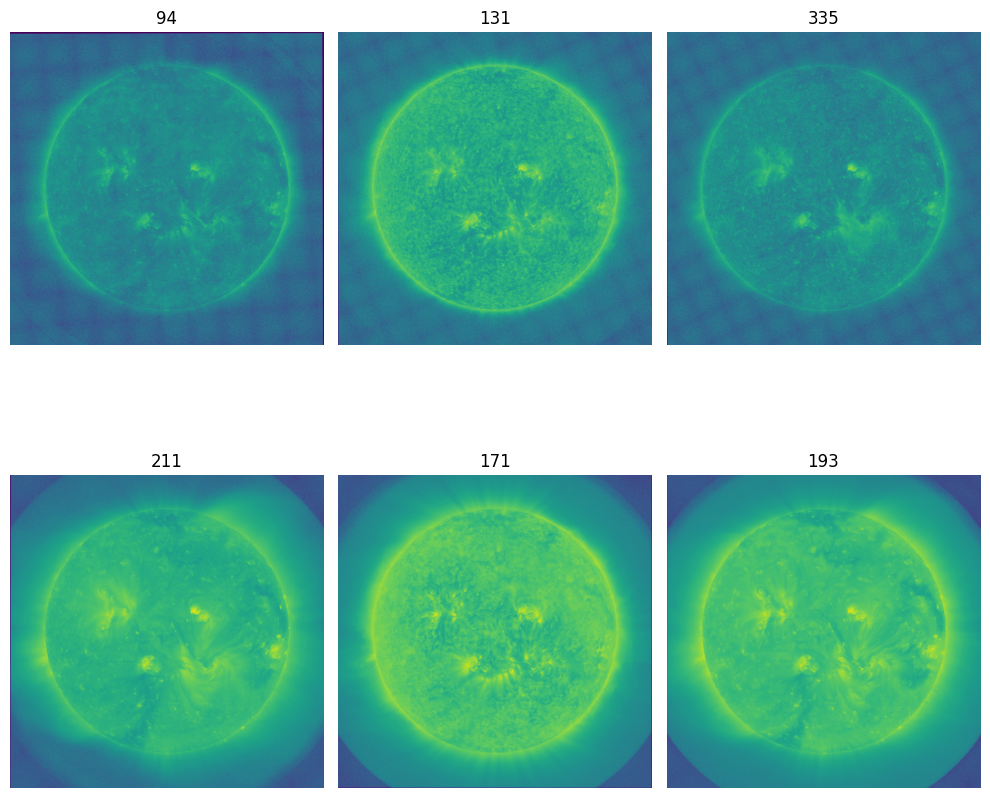

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,3, figsize=(10,10))

for axes , m in zip(ax.flatten(),sdo_prep):
  axes.imshow(m.data**0.1)
  axes.axis('off')
  axes.set_title(m.meta['wavelnth'])

plt.tight_layout()

In [ ]:
# save to compressed fits files
from astropy.io import fits

for m, wv in zip(sdo_prep, wvn):
    hdu = fits.CompImageHDU(m.data, m.fits_header)
    hdu.writeto('/content/drive/MyDrive/sdo_cor_hole_data/{0}/aia_prep_decon{1}.fits'.format(date,wv), overwrite=True)

In [ ]:
aia_map = Map('/content/drive/MyDrive/sdo_cor_hole_data/2010-05-23/aia_prep_decon171.fits')

In [11]:
for m, wv in zip(sdo_prep, wvn):
  m.save('/content/drive/MyDrive/sdo_cor_hole_data/{0}/aia_prep_decon{1}.fits'.format(date,wv), overwrite=True)

NameError: ignored

# Code for many files.

In [3]:
import astropy.time as atime
from astropy.coordinates import SkyCoord

from sunpy.map import Map

import numpy as np

import glob

from aiapy.calibrate import correct_degradation, normalize_exposure
from aiapy.calibrate.util import get_correction_table
from aiapy.calibrate import register, update_pointing, degradation
from aiapy.psf import psf, deconvolve

In [4]:
red_in = np.load('/content/drive/MyDrive/sdo_cor_hole_data/psf.npz')
psfs = red_in['psfs']
wvn_un = red_in['wvn_un']

In [21]:
date = dates[7]
wave = wvn_un[5]
files = glob.glob('/content/drive/MyDrive/sdo_cor_hole_data/{0}/*lev1_{1}*.fits'.format(date, wave))

IndexError: ignored

In [6]:
files[1:6]

['/content/drive/MyDrive/sdo_cor_hole_data/2017-05-23/aia_lev1_335a_2017_05_23t01_01_36_63z_image_lev1.fits',
 '/content/drive/MyDrive/sdo_cor_hole_data/2017-05-23/aia_lev1_335a_2017_05_23t01_01_48_63z_image_lev1.fits',
 '/content/drive/MyDrive/sdo_cor_hole_data/2017-05-23/aia_lev1_335a_2017_05_23t01_01_12_63z_image_lev1.fits',
 '/content/drive/MyDrive/sdo_cor_hole_data/2017-05-23/aia_lev1_335a_2017_05_23t01_01_24_63z_image_lev1.fits',
 '/content/drive/MyDrive/sdo_cor_hole_data/2017-05-23/aia_lev1_335a_2017_05_23t01_00_00_64z_image_lev1.fits']

In [7]:
sdo_maps = Map(files)

In [8]:
n_maps = len(sdo_maps)

for i in range(n_maps):
    m = sdo_maps[i]
    wv = m.meta['wavelnth']
    psf_wv = psfs[wvn_un == int(wv)]
    sdo_maps[i] = deconvolve(m, psf_wv[0])


In [9]:
#sdo_prep=[]
for i in range(n_maps):
    m = sdo_maps[i]
    m_temp = update_pointing(m)
    reg = register(m_temp)
    if reg.data.shape[0] != 4096:
        data = np.pad(reg.data,((0,2),(0,2)))
        meta = reg.fits_header
        meta['crpix1']+=1
        meta['crpix2']+=1
        reg = Map(data, meta)
    corr_deg = correct_degradation(reg)
    #norm_exp = normalize_exposure(corr_deg)
    #sdo_prep.append(corr_deg)
    sdo_maps[i] = corr_deg

/usr/local/lib/python3.10/dist-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/usr/local/lib/python3.10/dist-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/usr/local/lib/python3.10/dist-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 100 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/usr/local/lib/python3.10/dist-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/usr/local/lib/python3.10/dist-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.form

In [10]:
import matplotlib.pyplot as plt


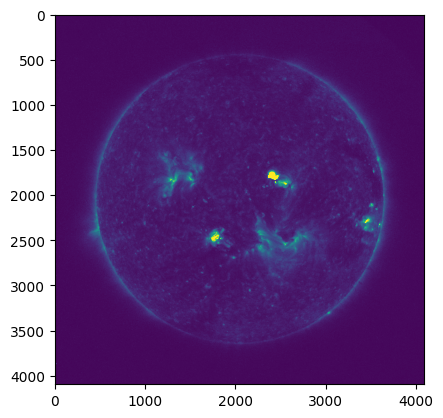

In [11]:
plt.imshow(sdo_maps[-1].data, vmax=1e2)

In [12]:
meta = sdo_maps[0].meta

In [13]:
avg_data = [m.data for m in sdo_maps]

In [14]:
del sdo_maps

In [15]:
avg_data = np.array(avg_data)

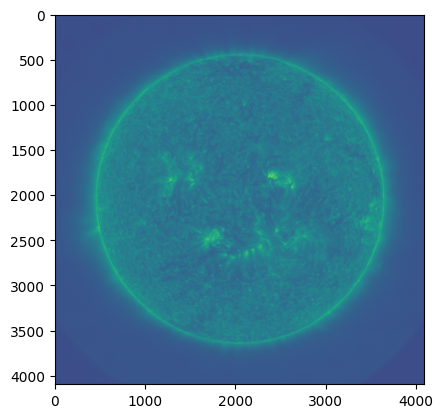

In [24]:
plt.imshow(avg_data.mean(axis=0)**0.2)

In [16]:
from scipy.ndimage import uniform_filter1d

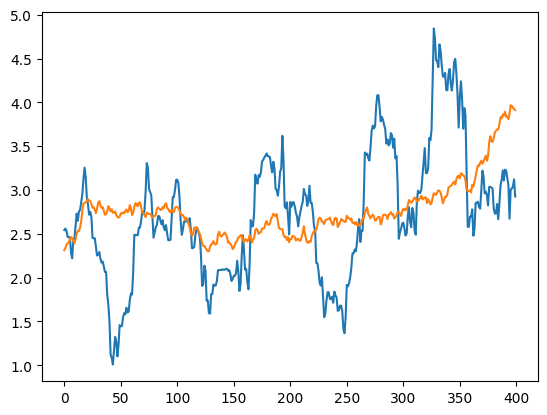

In [17]:
plt.plot(uniform_filter1d(avg_data[0, 0:400, 2000],30))
plt.plot(uniform_filter1d(avg_data.mean(axis=0)[0:400,2000],30))
#plt.plot(uniform_filter1d(avg_data[0, 0:400, 2000],1))
#plt.plot(uniform_filter1d(avg_data.mean(axis=0)[0:400,2000],1))

In [18]:
# new map containing average data and index from first maps

save_map = Map(avg_data.mean(axis=0), meta)

In [19]:
save_map.save('/content/drive/MyDrive/sdo_cor_hole_data/{0}/aia_prep_decon{1}_avg.fits'.format(date,wave), overwrite=True)

In [20]:
del avg_data